<a href="https://colab.research.google.com/github/MeenTers/VDAS_Project/blob/main/Car_Damage_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Rotation 3D model

In [ ]:
import os
import sys
import torch
import numpy as np
import json
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    631      0 --:--:-- --:--:-- --:--:--   631
100  404k    0  404k    0     0   909k      0 --:--:-- --:--:-- --:--:--  909k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-8o62vzdv
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-8o62vzdv
  Running command git checkout -q 3fc3ea507bfbf7e1c2d5023a6db202698206f91d
     |████████████████████████████████| 49 kB 4.6 MB/s 
     |████████████████████████████████| 596 kB 20.4 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.1-cp37-cp37m-linux_x86_64.whl size=30536978 sha256=77c29d904f837351a7321013e79d498228d89b843a78fe30a934d258af6f007f
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1a9dmt1/wheels/4c/03/f0/326bb241eb86a155a12f217c81e16

In [ ]:
!pip install utils

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread
from utils import *

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    FoVOrthographicCameras, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    PointsRenderer,
    PointsRasterizationSettings,
    PointsRasterizer
)

In [ ]:
# Set our device:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [ ]:
!pip install Params

# Import Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn, load, utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torchvision.models.vgg import model_urls
from os import path, listdir
model_urls['vgg19'] = model_urls['vgg19'].replace('https://', 'http://')

In [ ]:
from scipy.spatial import distance_matrix
from scipy.spatial import distance
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

In [ ]:
from PIL import Image 
import PIL

# VGG Model

In [ ]:
class VGG:
	def __init__(self):
		model = models.vgg19(pretrained=True, progress=True)
		model.classifier = nn.Sequential(*list(model.classifier.children())[:3])
		self.model = model.cuda().eval()

	def __call__(self, x):
		return self.model(x)

In [ ]:
vgg = VGG()

Downloading: "http://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# Features Extraction Function

In [ ]:
def get_features(model, loader):
    features = []
    with torch.no_grad():
        for batch, _ in tqdm(loader):
            if torch.cuda.is_available():
                batch = batch.cuda()
            b_features = model(batch).detach().cpu().numpy()
            for f in b_features:
                features.append(f)

    return features

# Loading the data Function

In [ ]:
def get_dataset(images_path):
  transform = transforms.Compose([
    transforms.Resize(size=32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = datasets.ImageFolder(images_path, transform=transform)
  loader = utils.data.DataLoader(dataset, batch_size=100, shuffle=False, num_workers=1, pin_memory=True)
  return dataset, loader

# Install TH SARABUN

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [ ]:
# !pip install -U --pre matplotlib  
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

# Compute Distance Function

In [ ]:
def get_euclidean(base_car,diff_view):
    dist = []
    for i in range(len(diff_view)):
        x = distance.euclidean(base_car[i],diff_view[i])
        dist.append(x)
    return(dist)

# Save Image Function

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# Step 1 Render the image using the views of the 3D model.

## base_car_id1

In [ ]:
obj1 = '/content/drive/MyDrive/VDAS_project/3D model/ID1.obj'

In [ ]:
# Get vertices, faces, and auxiliary information:
verts, faces, aux = load_obj(
    obj1,
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat"
     )

# Create a textures object
atlas = aux.texture_atlas

# Initialize the mesh with vertices, faces, and textures.
# Created Meshes object
capsule_mesh = Meshes(
    verts=[verts],
    faces=[faces.verts_idx],
    textures=TexturesAtlas(atlas=[atlas]),)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:533: UserWarning: Mtl file does not exist: /content/drive/MyDrive/VDAS_project/3D model/ID1.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [ ]:
print('We have {0} vertices and {1} faces.'.format(verts.shape[0], faces.verts_idx.shape[0]))

We have 32918 vertices and 22011 faces.


In [ ]:
# Initialize the camera with camera distance, elevation, and azimuth angle
R, T = look_at_view_transform(dist = 0, elev = 
                              0, azim = 0) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256 based on config.json 
raster_settings = RasterizationSettings(
    image_size = 1024, 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )

In [ ]:
# The textured phong shader interpolates the texture uv coordinates for 
# each vertex, and samples from a texture image.
shader = SoftPhongShader(device = device, cameras = cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

In [ ]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 4

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = [0,90,180,270]

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = 5, elev = 0, azim = azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)

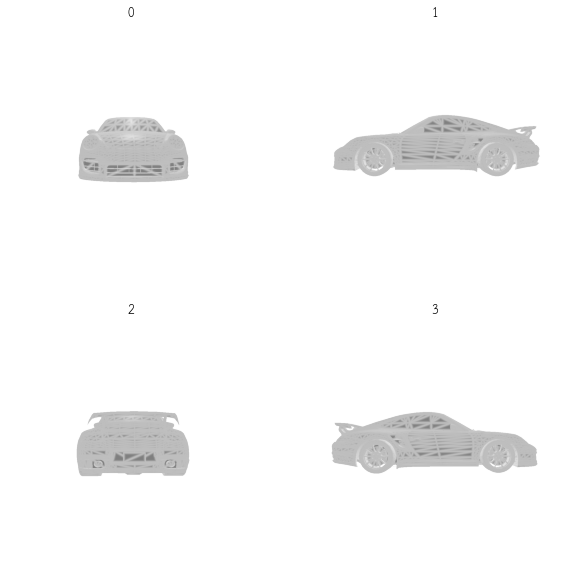

In [ ]:
plt.figure(figsize=(10, 10))
for i in list(range(4)) :
  plt.subplot(2,2,i+1)
  plt.imshow(images[i].cpu().numpy())
  plt.grid("off");
  plt.axis("off");
  plt.title(i)
plt.show()

In [ ]:
save = []
for i in range(len(images)) :
 ims =  tensor_to_image(images[i].cpu().numpy())
 save.append(ims)

In [ ]:
mkdir -p base_car/ID1/ID1

In [ ]:
for i in range(len(save)) :
  save[i].save("/content/base_car/ID1/ID1/"+'ID1_'+str(i)+".png")

## dmg_car_id1

In [ ]:
obj2 = '/content/drive/MyDrive/VDAS_project/3D model/ID1_dmg.obj'

In [ ]:
# Get vertices, faces, and auxiliary information:
verts, faces, aux = load_obj(
    obj2,
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat"
     )

# Create a textures object
atlas = aux.texture_atlas

# Initialize the mesh with vertices, faces, and textures.
# Created Meshes object
capsule_mesh = Meshes(
    verts=[verts],
    faces=[faces.verts_idx],
    textures=TexturesAtlas(atlas=[atlas]),)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:533: UserWarning: Mtl file does not exist: /content/drive/MyDrive/VDAS_project/3D model/ID1_dmg.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [ ]:
# Initialize the camera with camera distance, elevation, and azimuth angle
R, T = look_at_view_transform(dist = 0, elev = 
                              0, azim = 0) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256 based on config.json 
raster_settings = RasterizationSettings(
    image_size = 1024, 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )

In [ ]:
# The textured phong shader interpolates the texture uv coordinates for 
# each vertex, and samples from a texture image.
shader = SoftPhongShader(device = device, cameras = cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

In [ ]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 4

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = [0,90,180,270]

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = 5, elev = 0, azim = azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)

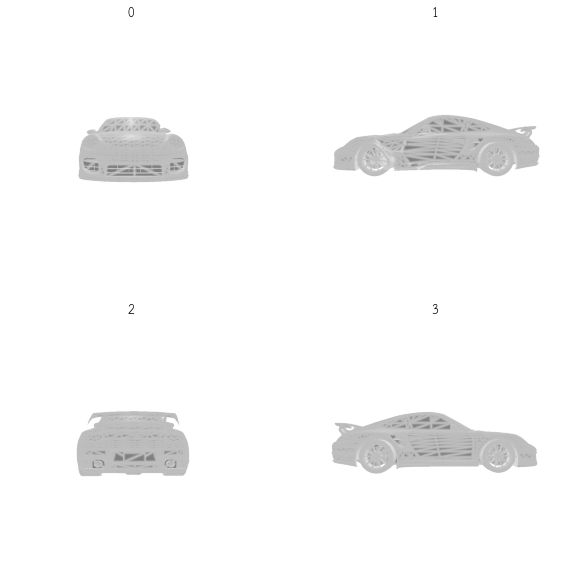

In [ ]:
plt.figure(figsize=(10, 10))
for i in list(range(4)) :
  plt.subplot(2,2,i+1)
  plt.imshow(images[i].cpu().numpy())
  plt.grid("off");
  plt.axis("off");
  plt.title(i)
plt.show()

In [ ]:
mkdir -p dmg_car/ID1/ID1

In [ ]:
save1 = []
for i in range(len(images)) :
 ims1 =  tensor_to_image(images[i].cpu().numpy())
 save1.append(ims1)

In [ ]:
for i in range(len(save1)) :
  save1[i].save("/content/dmg_car/ID1/ID1/"+'ID1dmg_'+str(i)+".png")

# Step 2 Compare View

In [ ]:
img1f  = cv2.imread(r'/content/base_car/ID1/ID1/ID1_0.png')
img1_1 = cv2.imread(r'/content/dmg_car/ID1/ID1/ID1dmg_0.png')
img1r  = cv2.imread(r'/content/base_car/ID1/ID1/ID1_1.png')
img1_2 = cv2.imread(r'/content/dmg_car/ID1/ID1/ID1dmg_1.png')
img1b  = cv2.imread(r'/content/base_car/ID1/ID1/ID1_2.png')
img1_3 = cv2.imread(r'/content/dmg_car/ID1/ID1/ID1dmg_2.png')
img1l  = cv2.imread(r'/content/base_car/ID1/ID1/ID1_3.png')
img1_4 = cv2.imread(r'/content/dmg_car/ID1/ID1/ID1dmg_3.png')

In [ ]:
car1_dataset , car1_loader = get_dataset(r'/content/base_car/ID1')
dmg1_dataset , dmg1_loader = get_dataset(r'/content/dmg_car/ID1')

In [ ]:
id1b = get_features(vgg,car1_loader)
id1d = get_features(vgg,dmg1_loader)

100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


In [ ]:
id1 = get_euclidean(id1b,id1d)
id1

[5.897854804992676, 13.390490531921387, 0.0, 0.0]

Text(300, 850, 'Distance = 13.39')

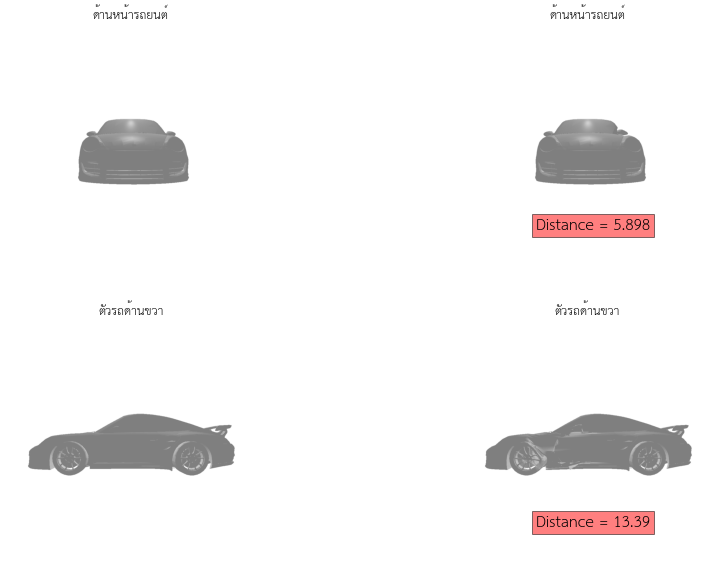

In [ ]:
# create figure
fig = plt.figure(figsize=(15, 10))
  # setting values to rows and column variables
rows = 2
columns = 2
  # Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  # showing image
plt.imshow(img1f)
plt.axis('off')
plt.title('ด้านหน้ารถยนต์')

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)  
# showing image
plt.imshow(img1_1)
plt.axis('off')
plt.title('ด้านหน้ารถยนต์')
plt.text(300,850,'Distance = '+str(round(id1[0],3)),fontsize = 15,bbox = dict(facecolor = 'red', alpha = 0.5))
        
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  # showing image
plt.imshow(img1r)
plt.axis('off')
plt.title('ตัวรถด้านขวา')

  # Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  # showing image
plt.imshow(img1_2)
plt.axis('off')
plt.title('ตัวรถด้านขวา')
plt.text(300,850,'Distance = '+str(round(id1[1],3)),fontsize = 15,bbox = dict(facecolor = 'red', alpha = 0.5))

Text(300, 850, 'Distance = 0.0')

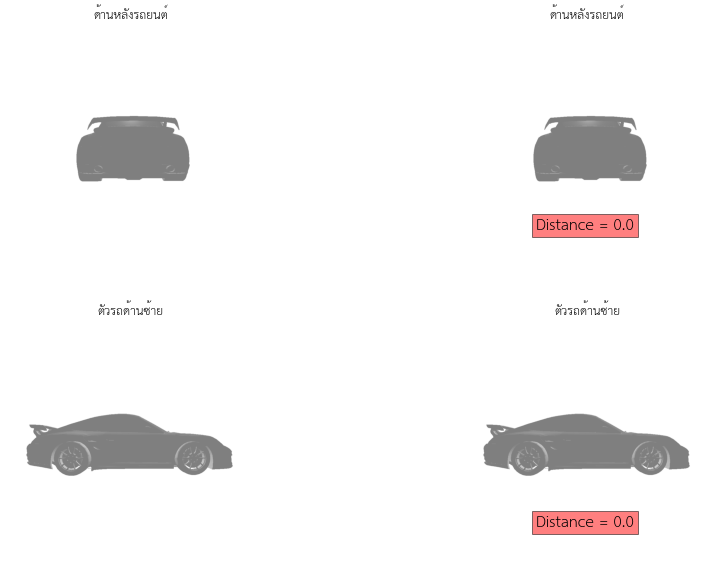

In [ ]:
# create figure
fig = plt.figure(figsize=(15, 10))
  # setting values to rows and column variables
rows = 2
columns = 2
  # Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  # showing image
plt.imshow(img1b)
plt.axis('off')
plt.title('ด้านหลังรถยนต์')

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)  
# showing image
plt.imshow(img1_3)
plt.axis('off')
plt.title('ด้านหลังรถยนต์')
plt.text(300,850,'Distance = '+str(round(id1[2],3)),fontsize = 15,bbox = dict(facecolor = 'red', alpha = 0.5))
        
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  # showing image
plt.imshow(img1l)
plt.axis('off')
plt.title('ตัวรถด้านซ้าย')

  # Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  # showing image
plt.imshow(img1_4)
plt.axis('off')
plt.title('ตัวรถด้านซ้าย')
plt.text(300,850,'Distance = '+str(round(id1[3],3)),fontsize = 15,bbox = dict(facecolor = 'red', alpha = 0.5))